In [1]:
import os
os.chdir("../")

In [1]:
import json
import pickle
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
from detectron2.engine import DefaultPredictor
from detectron2.data.datasets import register_coco_instances
from detectron2.engine import DefaultTrainer

from src.utils.config import load_config
from src.utils.detectron_utils import plot_samples, get_train_cfg, on_image

c:\Users\marce\miniconda3\envs\tfg\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'src'

In [3]:
global_config, local_config = load_config()

In [4]:
train_labels_file = "train.json"
train_2_labels_file = "train2.json"
test_labels_file = "test.json"
test_2_labels_file = "test2.json"

with open(
    Path(local_config["PATH"]["coco_labels"]).joinpath(train_labels_file)
) as file:
    coco_train_labels = json.load(file)

with open(
    Path(local_config["PATH"]["coco_labels"]).joinpath(test_labels_file)
) as file:
    coco_test_labels = json.load(file)

CONVERTING ALL LABELS TO SAME CLASS FOR INITIAL SIMPLICITY

In [5]:
for dataset in [coco_train_labels, coco_test_labels]:
    annotations = []
    for annotation in dataset["annotations"]:
        annotation["category_id"] = 1
        annotations.append(annotation)
    dataset["annotations"] = annotations
    dataset["categories"] = [dataset["categories"][0]]

In [6]:
with open(local_config["PATH"]["coco_labels"]+train_2_labels_file, mode="w", encoding="utf-8") as f:
    json.dump(coco_train_labels, f, ensure_ascii=False, indent=4)
with open(local_config["PATH"]["coco_labels"]+test_2_labels_file, mode="w", encoding="utf-8") as f:
    json.dump(coco_test_labels, f, ensure_ascii=False, indent=4)

DETECTRON2 CONFIGURATION

In [7]:
config_file_path = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
checkpoint_url = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
output_dir = local_config["PATH"]["models"]+"insance_segmentation\\"
num_classes = 1
device = "cuda"
train_dataset_name = "hold_detector_train"
train_images_path = local_config["PATH"]["coco_routes"]
train_annotations_path = local_config["PATH"]["coco_labels"]+train_2_labels_file
test_dataset_name = "hold_detector_test"
test_images_path = local_config["PATH"]["coco_routes"]
test_annotations_path = local_config["PATH"]["coco_labels"]+test_2_labels_file

In [8]:
register_coco_instances(
    name = train_dataset_name,
    metadata = {},
    json_file = train_annotations_path,
    image_root = train_images_path,
)
register_coco_instances(
    name = test_dataset_name,
    metadata = {},
    json_file = test_annotations_path,
    image_root = test_images_path,
)

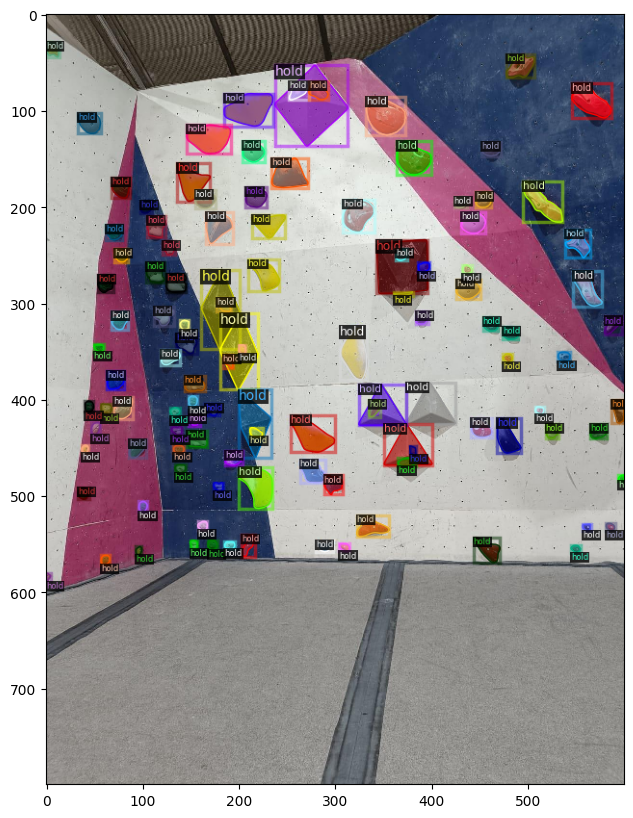

In [9]:
plot_samples(test_dataset_name, n_images=1, image_size=(10,10))

In [10]:
cfg_save_path = local_config["PATH"]["config"]+"hold-detector_cfg.pickle"

In [11]:
cfg = get_train_cfg(
    config_file_path=config_file_path,
    checkpoint_url=checkpoint_url,
    train_dataset_name=train_dataset_name,
    test_dataset_name=test_dataset_name,
    n_classes=num_classes,
    device=device,
    output_dir=output_dir
)
with open(cfg_save_path, "wb") as f:
    pickle.dump(cfg, f, protocol=pickle.HIGHEST_PROTOCOL)

##### TRAINING

In [12]:
# trainer = DefaultTrainer(cfg)
# trainer.resume_or_load(resume=False)
# trainer.train()

##### TESTING

In [13]:
with open(cfg_save_path, mode="rb") as f:
    cfg = pickle.load(f)
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESHOLD_TEST = 0.75
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)


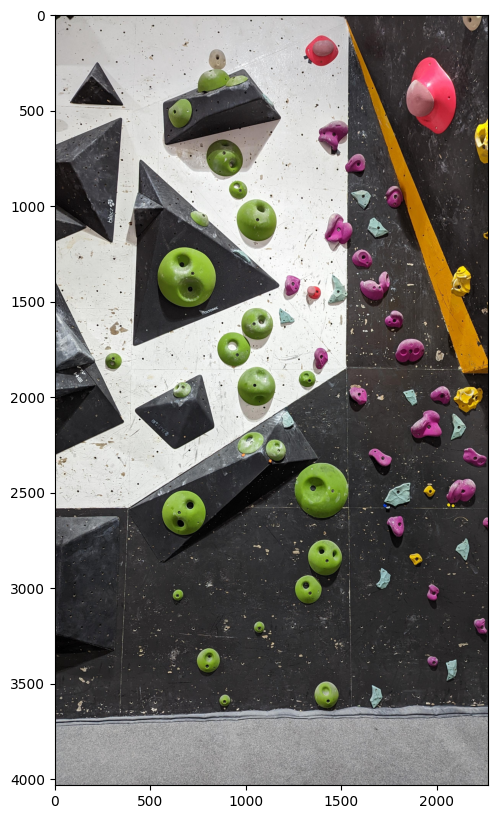

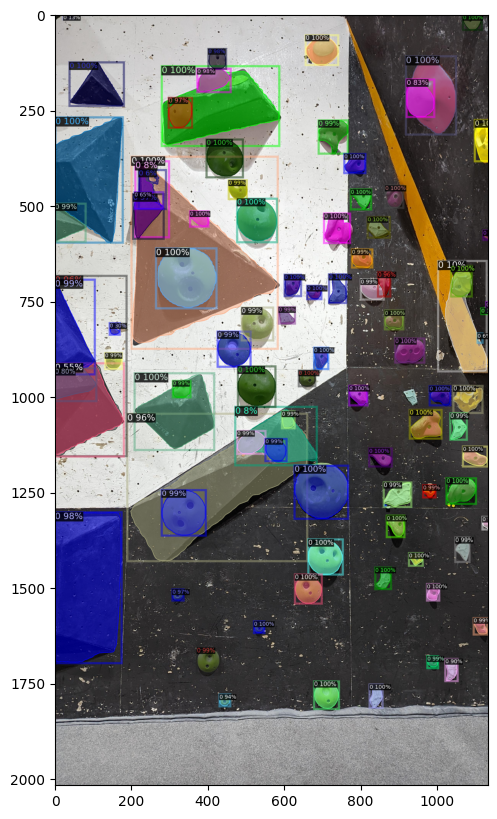

In [15]:
image_file = coco_test_labels["images"][14]["file_name"]
im = cv2.imread(local_config["PATH"]["coco_routes"]+image_file)
plt.figure(figsize = (15,10))
plt.imshow(im[:,:,::-1])
plt.show()
on_image(
    local_config["PATH"]["coco_routes"]+image_file,
    predictor,
    image_size = (15,10))